In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

In [27]:
def initialize_matrices(n, q, c):
    """初始化子群集隸屬度矩陣 Y 和最終群集隸屬度矩陣 Z"""
    Y = np.random.rand(n, q)
    Y /= np.sum(Y, axis=1, keepdims=True)
    
    Z = np.random.rand(q, c)
    Z /= np.sum(Z, axis=0, keepdims=True)
    
    return Y, Z

In [28]:
def update_subcluster_centers(data, Y, V, Z, q, c, r, alpha):
    """更新子群集中心 M"""
    M = np.zeros((q, data.shape[1]))
    for k in range(q):
        numerator = np.sum([data[i] * Y[i, k]**r for i in range(data.shape[0])], axis=0) + alpha * np.sum([V[l] * Z[k, l]**r for l in range(c)], axis=0)
        denominator = np.sum(Y[:, k]**r) + alpha * np.sum(Z[k, :]**r)
        M[k] = numerator / denominator
    return M

In [29]:
def update_final_cluster_centers(M, Z, r):
    """更新最終群集中心 V"""
    c = Z.shape[1]
    V = np.zeros((c, M.shape[1]))
    for l in range(c):
        numerator = np.sum([M[k] * Z[k, l]**r for k in range(M.shape[0])], axis=0)
        denominator = np.sum([Z[k, l]**r for k in range(M.shape[0])])
        V[l] = numerator / denominator
    return V


In [30]:
def update_membership_matrix_Y(data, centers, r):
    """更新隸屬度矩陣 Y 根據公式 (7)"""
    n, q = data.shape[0], centers.shape[0]
    Y = np.zeros((n, q))
    for i in range(n):
        for f in range(q):
            Y[i, f] = 1 / np.sum([(np.linalg.norm(data[i] - centers[f]) ** 2 / np.linalg.norm(data[i] - centers[j]) ** 2) ** (2 / (r - 1)) for j in range(q)])
    return Y

In [31]:
def update_membership_matrix_Z(M, V, r):
    """更新隸屬度矩陣 Z 根據公式 (9)"""
    q, c = M.shape[0], V.shape[0]
    Z = np.zeros((q, c))
    for k in range(q):
        for l in range(c):
            Z[k, l] = 1 / np.sum([(np.linalg.norm(M[k] - V[l]) ** 2 / np.linalg.norm(M[k] - V[j]) ** 2) ** (2 / (r - 1)) for j in range(c)])
    return Z

In [32]:

def fcmm(data, q, c, r, alpha, error=0.005, maxiter=100):
    """實現 FCMM 算法"""
    n = data.shape[0]
    Y, Z = initialize_matrices(n, q, c)
    V = np.random.rand(c, data.shape[1])  # 初始化 V
    iteration = 0
    with tqdm(total=maxiter, desc="FCMM Iteration") as pbar:
        while iteration < maxiter:
            M = update_subcluster_centers(data, Y, V, Z, q, c, r, alpha)
            V = update_final_cluster_centers(M, Z, r)
            Y_old = Y.copy()
            Z_old = Z.copy()
            
            Y = update_membership_matrix_Y(data, M, r)
            Z = update_membership_matrix_Z(M, V, r)
            
            if np.linalg.norm(Y - Y_old) < error and np.linalg.norm(Z - Z_old) < error:
                break
            iteration += 1
        pbar.update(1)
    return Y, Z, M, V

In [33]:
# Load Indian Pines Hyperspectral Dataset

# 高光譜影像數據，三維資料集，分別是長、寬、光譜波段
img = np.load('.\dataset\indian_pine\indianpinearray.npy')
# 地面真實值(Ground Truth)，二維的對應每個數據點的歸屬
gt = np.load('.\dataset\indian_pine\IPgt.npy')
classes = np.unique(gt)

#將三維數據降至二維
data = img.reshape(-1, img.shape[-1])

q, c = 32, 16  # Number of subclusters and clusters
r = 1.33  # Fuzzy factor
alpha = 8.3  # Balance parameter

Y, Z, M, V = fcmm(data, q, c, r, alpha)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\MaseLab Master\AppData\Local\Temp\ipykernel_12388\1374081592.py:4: SyntaxWarning: invalid escape sequence '\d'
  img = np.load('.\dataset\indian_pine\indianpinearray.npy')
C:\Users\MaseLab Master\AppData\Local\Temp\ipykernel_12388\1374081592.py:6: SyntaxWarning: invalid escape sequence '\d'
  gt = np.load('.\dataset\indian_pine\IPgt.npy')
FCMM Iteration:   0%|          | 0/100 [01:15<?, ?it/s]


KeyboardInterrupt: 

Labels shape: (21025,)
Clustered image shape: (145, 145)


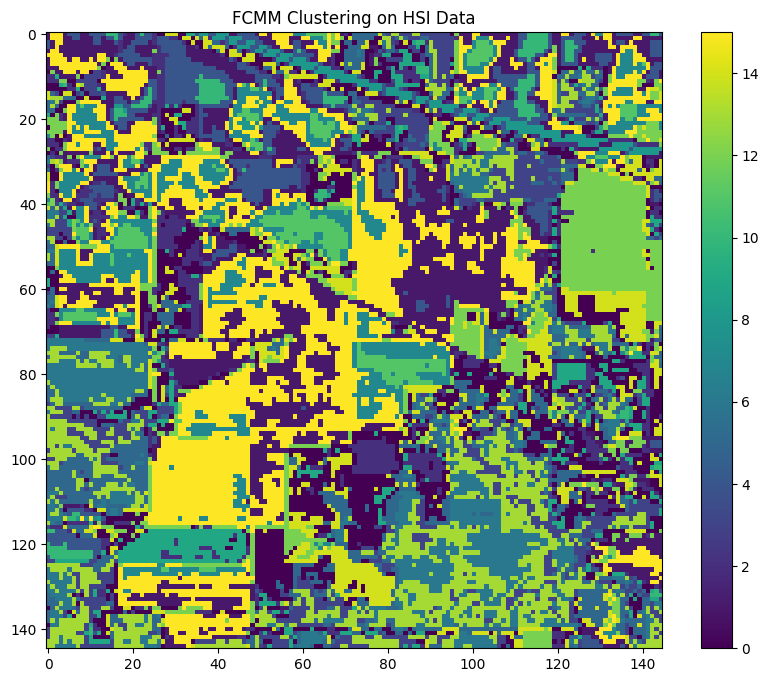

In [ ]:
print("Y", Y.shape)
print("Z", Z.shape)
print("Subcluster centers (M):", M.shape)
print("Final cluster centers (V):", V.shape)
# 獲取最終群集標籤
labels = np.argmax(Y @ Z, axis=1)
print("Labels shape:", labels.shape)  # 輸出 labels 的形狀
clustered_img = labels.reshape(img.shape[:2])
print("Clustered image shape:", clustered_img.shape)  # 輸出重塑後的 clustered_img 的形狀

plt.figure(figsize=(10, 8))
plt.imshow(clustered_img, cmap='viridis')
plt.colorbar()
plt.title('FCMM Clustering on HSI Data')
plt.show()

Accuracy: 27.24%
Overall Accuracy (OA): 8.94%
Average Accuracy (AA): 2.04%


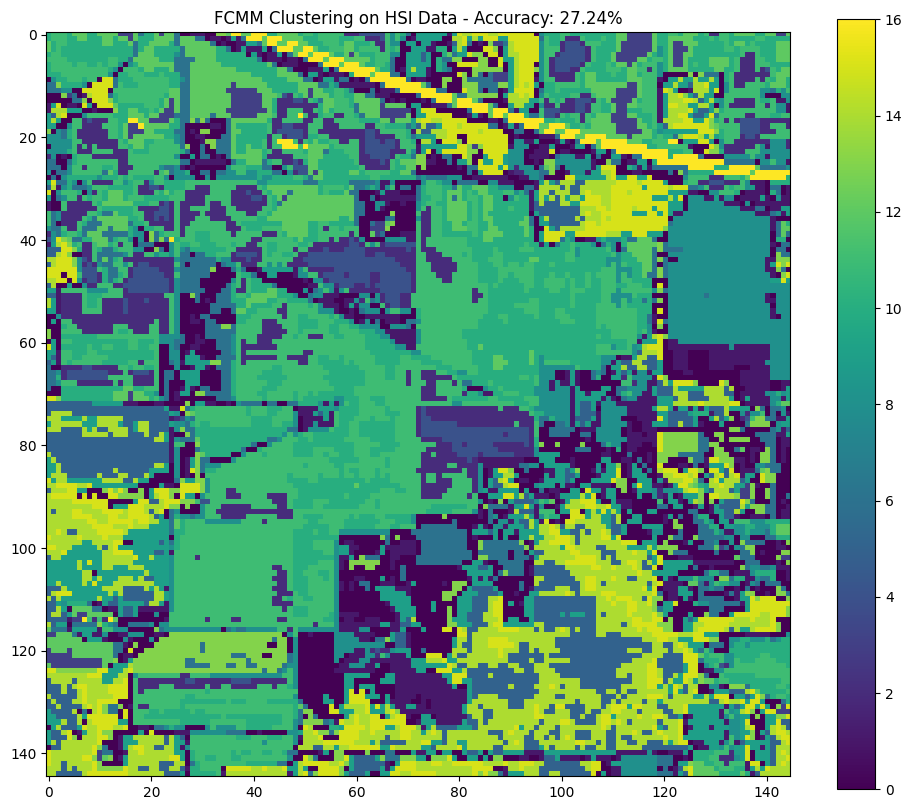

In [ ]:
# 並且已經有 gt 加載和重塑為一維向量
gt_flat = gt.flatten()

# 計算混淆矩陣
cm = confusion_matrix(gt_flat, labels)
# print("Confusion Matrix:", cm)

# 使用匈牙利算法找到最佳標籤對應
row_ind, col_ind = linear_sum_assignment(-cm)  # 對成本矩陣取負值以求最大化

# 建立標籤映射，根據找到的對應關係重映射 FCMM 的結果
label_mapping = {col: row for col, row in zip(col_ind, row_ind)}
remapped_labels = np.array([label_mapping[label] for label in labels])

# 計算重映射後的準確率
accuracy = np.sum(remapped_labels == gt_flat) / gt_flat.size
print(f"Accuracy: {accuracy * 100:.2f}%")

# 計算整體精確度 (Overall Accuracy, OA)
OA = np.trace(cm) / np.sum(cm)
print(f"Overall Accuracy (OA): {OA * 100:.2f}%")

# 計算平均精確度 (Average Accuracy, AA)
class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
AA = np.mean(class_accuracies)
print(f"Average Accuracy (AA): {AA * 100:.2f}%")

# 可視化重映射後的分群結果
remapped_clustered_img = remapped_labels.reshape(img.shape[:2])

plt.figure(figsize=(12, 10))
plt.imshow(remapped_clustered_img, cmap='viridis')
plt.colorbar()
plt.title(f'FCMM Clustering on HSI Data - Accuracy: {accuracy * 100:.2f}%')
plt.show()